In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.stats import weibull_min, beta, norm, spearmanr
from scipy.optimize import minimize_scalar
from scipy.stats import gaussian_kde

In [74]:
# import wind and solar data from file
df = pd.read_csv('data/bids/bids_values.csv')

In [75]:
wind_data = df['bids_1'].to_numpy()
pv_data = df['bids_2'].to_numpy()

Text(0, 0.5, 'Solar Power Production (MW)')

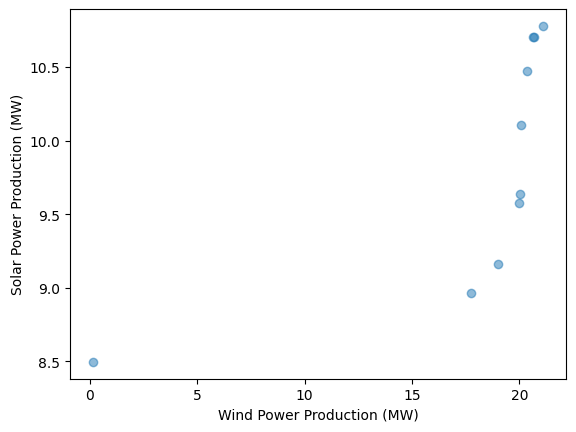

In [76]:
# plot correlation, i.e. scatter plot
plt.scatter(wind_data, pv_data, alpha=0.5)
plt.xlabel('Wind Power Production (MW)')
plt.ylabel('Solar Power Production (MW)')


Captured Correlation: 1.000 (Negative means good balancing!)


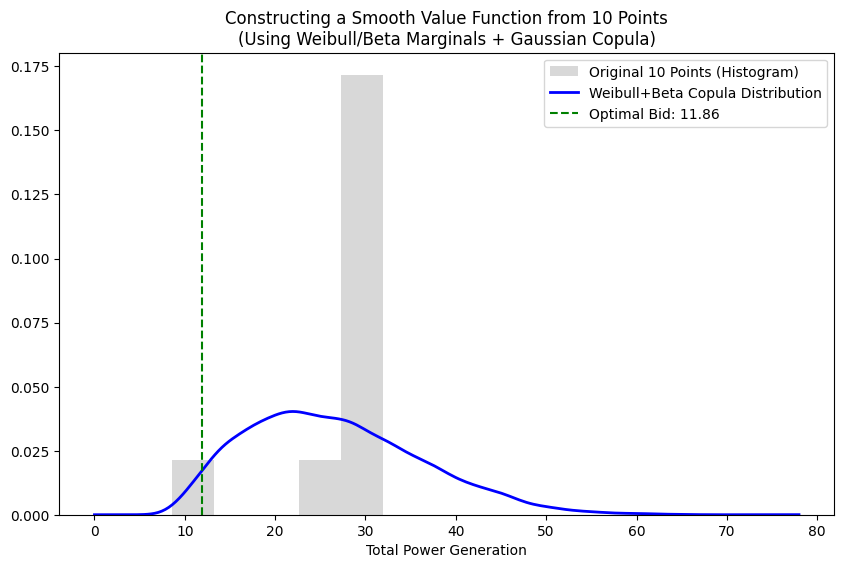

In [77]:
# 1. INPUT: Your 10 sparse data points
# Note: PV must be scaled to [0, 1] for Beta fitting usually, 
# but scipy.stats.beta.fit handles location/scale automatically.
# wind_data = np.array([1.0, 1.2, 0.5, 3.0, 1.3, 1.2, 1.1, 0.2, 1.4, 3.5])
# pv_data   = np.array([4.0, 4.2, 0.5, 1.0, 4.1, 4.3, 0.2, 4.1, 3.8, 1.2])

# 2. FITTING THE MARGINALS (The "Physics")
# Wind -> Weibull
# floc=0 fixes the location at 0 (wind can't be negative)
w_params = weibull_min.fit(wind_data, floc=0) 

# Solar -> Beta
# We let it find the bounds, or we can fix them if we know installed capacity
b_params = beta.fit(pv_data)

# 3. CAPTURING THE CORRELATION (The "Portfolio Effect")
# We calculate the correlation structure of the raw data
# We use Spearman Rank correlation as it captures monotonic relationships better
corr, _ = spearmanr(wind_data, pv_data)
cov_matrix = [[1.0, corr], [corr, 1.0]]

print(f"Captured Correlation: {corr:.3f} (Negative means good balancing!)")

# 4. SIMULATION (Monte Carlo with Copula)
# We generate 10,000 scenarios that follow the Weibull/Beta shapes 
# BUT respect the correlation found in your 10 points.
num_simulations = 10000

# Step A: Generate correlated Gaussian samples (The "Copula" engine)
mv_norm = np.random.multivariate_normal([0, 0], cov_matrix, size=num_simulations)
# Step B: Transform Gaussian to Uniform [0,1] (CDF)
norm_cdf = norm.cdf(mv_norm)
# Step C: Transform Uniform to Weibull/Beta (Inverse CDF / PPF)
sim_wind = weibull_min.ppf(norm_cdf[:, 0], *w_params)
sim_pv   = beta.ppf(norm_cdf[:, 1], *b_params)

# The smooth joint distribution
total_gen_simulated = sim_wind + sim_pv

# 5. OPTIMIZATION (Calculating the Value Function)
# Now we have a dense, smooth distribution of 10,000 points instead of 10 steps
def get_reliability_smooth(bid):
    # Count how many simulated scenarios satisfy the bid
    # This creates a very smooth probability curve
    return np.mean(total_gen_simulated >= bid)

def objective_function(b):
    gamma = get_reliability_smooth(b)
    # Maximize: Bid * (Gamma - 3*(1-Gamma)) -> Maximize Bid * (4*Gamma - 3)
    # Minimize negative of that
    return -(b * (4 * gamma - 3))

# Find optimal bid
res = minimize_scalar(objective_function, bounds=(0, np.max(total_gen_simulated)), method='bounded')
opt_bid = res.x

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# Plot the 10 original points (The "Steps")
plt.hist(wind_data + pv_data, bins=5, alpha=0.3, density=True, color='gray', label='Original 10 Points (Histogram)')

# Plot the new "Physically Correct" Smooth Distribution
density = gaussian_kde(total_gen_simulated) # Just for visualization of the result
x_grid = np.linspace(0, np.max(total_gen_simulated), 200)
plt.plot(x_grid, density(x_grid), color='blue', linewidth=2, label='Weibull+Beta Copula Distribution')

plt.axvline(opt_bid, color='green', linestyle='--', label=f'Optimal Bid: {opt_bid:.2f}')
plt.title("Constructing a Smooth Value Function from 10 Points\n(Using Weibull/Beta Marginals + Gaussian Copula)")
plt.xlabel("Total Power Generation")
plt.legend()
plt.show()

Spearman corr (measured): 0.9999999999999999
SCENARIO             | OPT BID (MW) | RELIABILITY  | VALUE ($)   
-----------------------------------------------------------------
Wind Only            | 5.506        | 91.37%       | 3.605       
PV Only              | 8.494        | 100.00%      | 8.494       
-----------------------------------------------------------------
Sum of Individuals   | -            | -            | 12.100      
Joint Coalition      | 11.820       | 96.87%       | 10.340      
-----------------------------------------------------------------

SUPERADDITIVITY CHECK:
FAILURE: Superadditivity not achieved. (Synergy: -1.760)


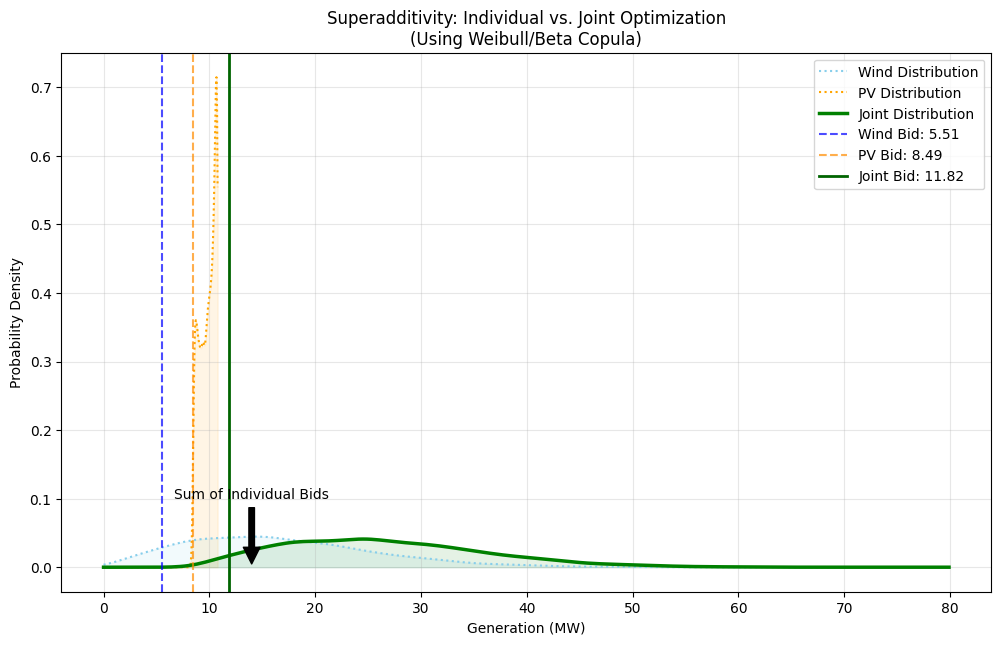

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min, beta, norm, spearmanr, gaussian_kde
from scipy.optimize import minimize_scalar

# --- 1. SETUP & DATA ---
size = len(wind_data)  # Assuming wind_data and pv_data are defined with your

# --- 2. FIT MARGINALS (PHYSICS) ---
w_params = weibull_min.fit(wind_data, floc=0) 
b_params = beta.fit(pv_data)

# --- 3. CORRELATION (COPULA) ---
corr, _ = spearmanr(wind_data, pv_data)
print("Spearman corr (measured):", corr)

# Option 1 — clamp the measured correlation to a max (safe, simple)
# corr = np.clip(corr, -0.99, 0.9)

# # Option 2 — blend measured corr with a target_corr (alpha=0 uses target only)
# target_corr = 0.3
# alpha = 0.0  # set 0..1. 0 -> use target_corr, 1 -> use measured corr
# corr = alpha * corr + (1 - alpha) * target_corr

# Option 3 — add small noise to PV (or wind) before computing correlation to decorrelate:
# pv_data_noisy = pv_data + np.random.normal(0, 0.05 * np.std(pv_data), size=pv_data.shape)
# corr, _ = spearmanr(wind_data, pv_data_noisy)

cov_matrix = [[1.0, corr], [corr, 1.0]]

# --- 4. SIMULATION (10,000 Scenarios) ---
num_simulations = 10000
mv_norm = np.random.multivariate_normal([0, 0], cov_matrix, size=num_simulations)
norm_cdf = norm.cdf(mv_norm)

# Transform to physical variables
sim_wind = weibull_min.ppf(norm_cdf[:, 0], *w_params)
sim_pv   = beta.ppf(norm_cdf[:, 1], *b_params)
sim_joint = sim_wind + sim_pv

# --- 5. GENERIC OPTIMIZATION FUNCTION ---
def solve_optimization(data_array, name):
    """
    Finds optimal bid b* and value v* for a given array of scenarios.
    Objective: Maximize b * (4*gamma - 3)
    """
    # Helper to calculate reliability gamma(b) for any b
    def get_reliability(b):
        return np.mean(data_array >= b)

    # Objective function (negative because we minimize)
    def objective(b):
        gamma = get_reliability(b)
        # Value = b * (gamma - 3*(1-gamma)) = b * (4*gamma - 3)
        val = b * (4 * gamma - 3)
        return -val 

    # Optimize
    max_bound = np.max(data_array)
    res = minimize_scalar(objective, bounds=(0, max_bound), method='bounded')
    
    b_star = res.x
    v_star = -res.fun # Flip sign back to positive
    gamma_star = get_reliability(b_star)
    
    return b_star, v_star, gamma_star

# --- 6. RUN OPTIMIZATION FOR ALL CASES ---
b_w, v_w, g_w = solve_optimization(sim_wind, "Wind Only")
b_pv, v_pv, g_pv = solve_optimization(sim_pv, "PV Only")
b_joint, v_joint, g_joint = solve_optimization(sim_joint, "Joint Coalition")

# --- 7. RESULTS & ANALYSIS ---
print(f"{'SCENARIO':<20} | {'OPT BID (MW)':<12} | {'RELIABILITY':<12} | {'VALUE ($)':<12}")
print("-" * 65)
print(f"{'Wind Only':<20} | {b_w:<12.3f} | {g_w:<12.2%} | {v_w:<12.3f}")
print(f"{'PV Only':<20} | {b_pv:<12.3f} | {g_pv:<12.2%} | {v_pv:<12.3f}")
print("-" * 65)
sum_individual = v_w + v_pv
print(f"{'Sum of Individuals':<20} | {'-':<12} | {'-':<12} | {sum_individual:<12.3f}")
print(f"{'Joint Coalition':<20} | {b_joint:<12.3f} | {g_joint:<12.2%} | {v_joint:<12.3f}")
print("-" * 65)

synergy = v_joint - sum_individual
print(f"\nSUPERADDITIVITY CHECK:")
if synergy > 0:
    print(f"SUCCESS: The coalition gained +{synergy:.3f} value ({(synergy/sum_individual)*100:.1f}% increase).")
    print("Reason: The portfolio effect smoothed the risk profile, allowing a more aggressive aggregate bid.")
else:
    print(f"FAILURE: Superadditivity not achieved. (Synergy: {synergy:.3f})")

# --- 8. VISUALIZATION ---
plt.figure(figsize=(12, 7))

# Create X-axis grids for smooth plotting
x_w = np.linspace(0, max(sim_wind), 200)
x_p = np.linspace(0, max(sim_pv), 200)
x_j = np.linspace(0, max(sim_joint), 200)

# KDE for visualization
kde_w = gaussian_kde(sim_wind)(x_w)
kde_p = gaussian_kde(sim_pv)(x_p)
kde_j = gaussian_kde(sim_joint)(x_j)

# Plot Densities
plt.plot(x_w, kde_w, color='skyblue', label='Wind Distribution', linestyle=':')
plt.fill_between(x_w, kde_w, color='skyblue', alpha=0.1)

plt.plot(x_p, kde_p, color='orange', label='PV Distribution', linestyle=':')
plt.fill_between(x_p, kde_p, color='orange', alpha=0.1)

plt.plot(x_j, kde_j, color='green', label='Joint Distribution', linewidth=2.5)
plt.fill_between(x_j, kde_j, color='green', alpha=0.1)

# Plot Optimal Bids
plt.axvline(b_w, color='blue', linestyle='--', alpha=0.7, label=f'Wind Bid: {b_w:.2f}')
plt.axvline(b_pv, color='darkorange', linestyle='--', alpha=0.7, label=f'PV Bid: {b_pv:.2f}')
plt.axvline(b_joint, color='darkgreen', linestyle='-', linewidth=2, label=f'Joint Bid: {b_joint:.2f}')

# Annotation arrows
plt.annotate('Sum of Individual Bids', xy=(b_w + b_pv, 0), xytext=(b_w + b_pv, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

plt.title("Superadditivity: Individual vs. Joint Optimization\n(Using Weibull/Beta Copula)")
plt.xlabel("Generation (MW)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()